# Preparation

In [73]:
dataset = 'fmnist'
ntrain = 0 ; latent_dim = 9
steps = 500
learning_rate = 0.001
batch_size = 16


In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [75]:
import sys
sys.version

'3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]'

In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

def data(ntrain, latent_dim, dataset):
    transform = transforms.Compose([
        transforms.Resize((16, 16)),
        transforms.ToTensor()
    ])
    
    if dataset == 'mnist':
        train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
        test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transform)
    elif dataset == 'fmnist':
        train_dataset = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
        test_dataset = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)
    elif dataset == 'kmnist':
        train_dataset = datasets.KMNIST(root='data', train=True, download=True, transform=transform)
        test_dataset = datasets.KMNIST(root='data', train=False, download=True, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))
    
    x_train, y_train = next(iter(train_loader))
    x_test, y_test = next(iter(test_loader))

    x_train = x_train.numpy()
    y_train = y_train.numpy()
    x_test = x_test.numpy()
    y_test = y_test.numpy()

    x_train_filter = np.where(y_train == ntrain)[0]
    sampled_train_indices = np.random.choice(x_train_filter, 600, replace=False)
    X_train = x_train[sampled_train_indices]
    Y_train = y_train[sampled_train_indices]

    X_test = []
    Y_test = []
    
    ntrain_indices = np.where(y_test == ntrain)[0]
    sampled_ntrain_indices = np.random.choice(ntrain_indices, 100, replace=False)
    X_test.append(x_test[sampled_ntrain_indices])
    Y_test.append(y_test[sampled_ntrain_indices])
    
    for class_label in range(10):
        if class_label != ntrain:
            class_indices = np.where(y_test == class_label)[0]
            sampled_indices = np.random.choice(class_indices, 10, replace=False)
            X_test.append(x_test[sampled_indices])
            Y_test.append(y_test[sampled_indices])
    
    X_test = np.concatenate(X_test)
    Y_test = np.concatenate(Y_test)
    
    print('x_test:', x_test.shape)
    print('y_train:', y_train.shape)
    print('y_test:', y_test.shape)
    print('X_train:', X_train.shape)
    print('X_test:', X_test.shape)
    print('Y_train:', Y_train.shape)
    print('Y_test:', Y_test.shape)
    return x_train, y_train, x_test, y_test, X_train, X_test, Y_train, Y_test

x_train, y_train, x_test, y_test, X_train, X_test, Y_train, Y_test = data(ntrain, latent_dim, dataset)

x_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1)

x_test: (10000, 1, 16, 16)
y_train: (60000,)
y_test: (10000,)
X_train: (600, 1, 16, 16)
X_test: (190, 1, 16, 16)
Y_train: (600,)
Y_test: (190,)


In [77]:

from torchsummary import summary
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import os

class SVDD(nn.Module):
    def __init__(self, latent_dim, num_filters=2):
        super(SVDD, self).__init__()
        self.num_filters = num_filters
        self.latent_dim = latent_dim
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.num_filters, kernel_size=2, stride=1, padding='same')
        self.bn1 = nn.BatchNorm2d(num_features=self.num_filters)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=self.num_filters, out_channels=self.num_filters, kernel_size=2, stride=1, padding='same')
        self.bn2 = nn.BatchNorm2d(num_features=self.num_filters)
        self.conv3 = nn.Conv2d(in_channels=self.num_filters, out_channels=1, kernel_size=2, stride=1, padding='same')
        self.bn3 = nn.BatchNorm2d(num_features=1)
        self.fc1 = nn.Linear(1 * 2 * 2, self.latent_dim)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 1 * 2 * 2)
        x = self.fc1(x)
        return x

svdd = SVDD(latent_dim=latent_dim)
svdd = svdd.cuda()
summary(svdd, (1, 16, 16))

weight_decay = 0.001
optimizer = torch.optim.Adam(svdd.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_history = []

c = None

def initialize_center_c(dataloader, model):
    model.eval()
    with torch.no_grad():
        n_samples = 0
        center = torch.zeros(model.latent_dim, device=next(model.parameters()).device)
        for data in dataloader:
            inputs, _ = data
            inputs = inputs.cuda()  
            outputs = model(inputs)
            center += torch.sum(outputs, dim=0)
            center /= outputs.shape[0]
            break
    model.train()
    return center

def train(num_steps):
    global c
    for step in range(num_steps):
        data = next(iter(train_dataloader))
        inputs, _ = data  
        inputs = inputs.cuda()
        optimizer.zero_grad()


        if c is None:
            c = initialize_center_c(train_dataloader, svdd)

        outputs = svdd(inputs)
        loss = torch.mean(torch.sum((outputs - c) ** 2, dim=1))

        l2_reg = torch.tensor(0., device=inputs.device)
        for param in svdd.parameters():
            l2_reg += torch.norm(param)
        loss += weight_decay * l2_reg

        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

        if step % 10 == 0:
            print('Step: {} | Loss: {:.6f}'.format(step, loss.data))

train(num_steps=500)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 2, 16, 16]              10
       BatchNorm2d-2            [-1, 2, 16, 16]               4
         MaxPool2d-3              [-1, 2, 8, 8]               0
            Conv2d-4              [-1, 2, 8, 8]              18
       BatchNorm2d-5              [-1, 2, 8, 8]               4
         MaxPool2d-6              [-1, 2, 4, 4]               0
            Conv2d-7              [-1, 1, 4, 4]               9
       BatchNorm2d-8              [-1, 1, 4, 4]               2
         MaxPool2d-9              [-1, 1, 2, 2]               0
           Linear-10                    [-1, 9]              45
Total params: 92
Trainable params: 92
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size 

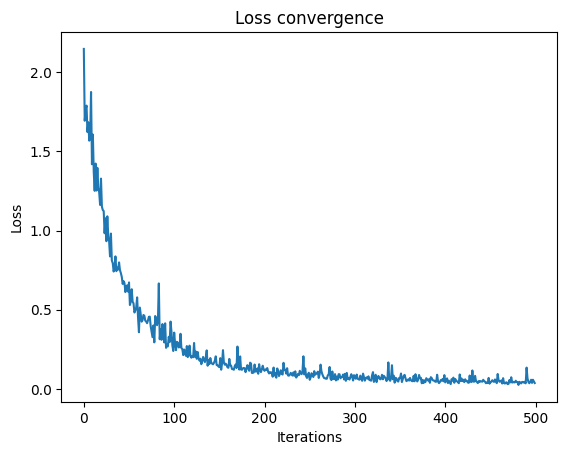

In [78]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import os

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
loss_image_path = f'./records/loss_{timestamp}.png'

plt.style.use('default')
plt.plot(loss_history)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss convergence")
plt.savefig(loss_image_path)
plt.show()

In [79]:

def test(model, test_dataloader, ntrain):
    global c  
    y_true = []
    y_pred = []
    model = model.cuda()

    for data, labels in test_dataloader:
        inputs = data.cuda()  
        labels = labels.cuda()

        outputs = model(inputs.float())
        dist = torch.sum((outputs - c) ** 2, dim=1)

        for label, d in zip(labels.cpu().numpy(), dist.detach().cpu().numpy()):
            if label == ntrain:
                y_true.append(0)
            else:
                y_true.append(1)
            y_pred.append(d.item())

    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)

    return auc, y_pred, y_true, fpr, tpr

auc, y_pred, y_true, fpr, tpr = test(svdd, test_dataloader, 0)

(array([100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  90.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

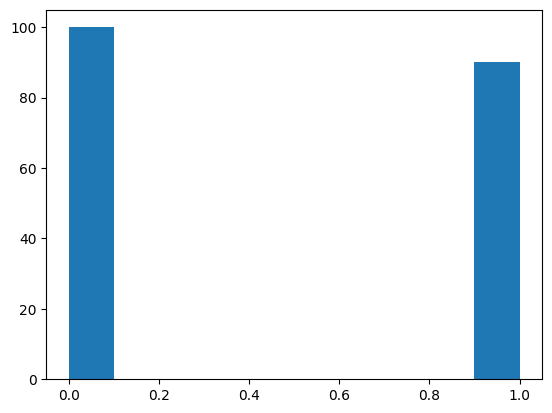

In [80]:
plt.hist(y_true)

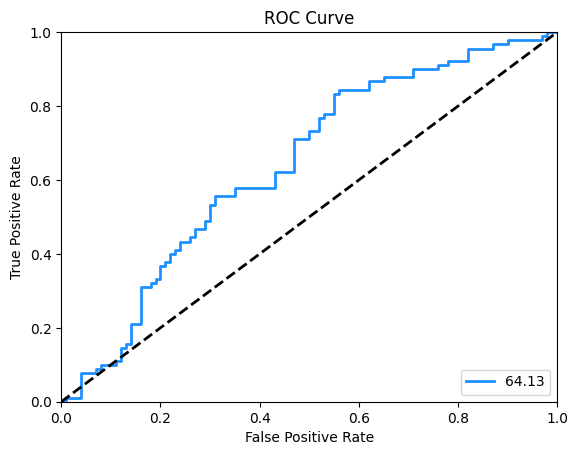

In [81]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import os

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='dodgerblue', lw=lw, label="{:.2f}".format(auc * 100))
plt.plot([0, 1], [0, 1], color="black", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
roc_image_path = f'./records/roc_curve_{timestamp}.png'
plt.savefig(roc_image_path)
plt.show()

def save_auc_to_file(auc, file_name):
    auc = "{:.2f}".format(auc * 100)
    directory = os.path.dirname(file_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    if not os.path.exists(file_name):
        with open(file_name, 'w') as f:
            f.write("AUC Results\n")
    with open(file_name, 'a') as f:
        f.write(str(auc) + "\n")

auc_file_path = "./records/auc.txt"
save_auc_to_file(auc, auc_file_path)
